In [127]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
import torchvision.transforms.functional as VF

bs = 100
# MNIST Dataset
train_dataset = datasets.MNIST(root='~/Datasets/mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='~/Datasets/mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

In [128]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.rand_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

# build model
device = torch.device("mps")
vae = VAE(x_dim=784, h_dim1= 4096, h_dim2=4096, z_dim=8)
vae = vae.to(device)

In [129]:
optimizer = optim.Adam(vae.parameters())
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.mse_loss(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [130]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [131]:
def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            recon, mu, log_var = vae(data)
            
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [132]:
for epoch in range(1, 20):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 181.868027
Train Epoch: 1 [10000/60000 (17%)]	Loss: 41.074902
Train Epoch: 1 [20000/60000 (33%)]	Loss: 29.806682
Train Epoch: 1 [30000/60000 (50%)]	Loss: 29.648279
Train Epoch: 1 [40000/60000 (67%)]	Loss: 25.434399
Train Epoch: 1 [50000/60000 (83%)]	Loss: 25.358494
====> Epoch: 1 Average loss: 31.4147
====> Test set loss: 23.4404
Train Epoch: 2 [0/60000 (0%)]	Loss: 22.448240
Train Epoch: 2 [10000/60000 (17%)]	Loss: 24.844666
Train Epoch: 2 [20000/60000 (33%)]	Loss: 21.422759
Train Epoch: 2 [30000/60000 (50%)]	Loss: 22.443904
Train Epoch: 2 [40000/60000 (67%)]	Loss: 21.081401
Train Epoch: 2 [50000/60000 (83%)]	Loss: 21.383474
====> Epoch: 2 Average loss: 22.4957
====> Test set loss: 21.7416
Train Epoch: 3 [0/60000 (0%)]	Loss: 24.324041
Train Epoch: 3 [10000/60000 (17%)]	Loss: 21.949436
Train Epoch: 3 [20000/60000 (33%)]	Loss: 20.919121
Train Epoch: 3 [30000/60000 (50%)]	Loss: 20.697300
Train Epoch: 3 [40000/60000 (67%)]	Loss: 21.798787
Train Epoch: 3 

In [135]:
with torch.no_grad():
    z = (torch.randn(64, 8)).to(device)
    sample = vae.decoder(z).to(device)

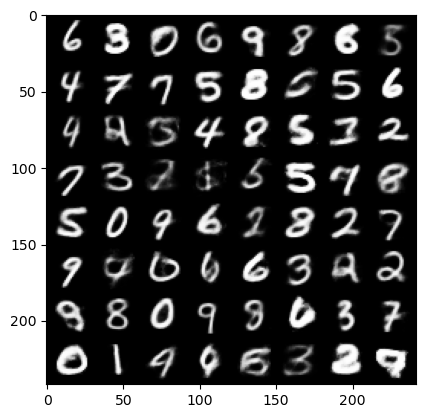

In [136]:
images = sample.view(64, 1, 28, 28).cpu()
grid = make_grid(images)
plt.imshow(grid.permute(1,2,0))